In [1]:
import numpy as np
import pandas as pd
import math
import sklearn.preprocessing
import datetime
from TimeBasedCV import TimeBasedCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import make_scorer, r2_score
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# more

In [ ]:
# df = pd.read_csv('data/factors_1965.csv', parse_dates=['DATE'])

In [2]:
# with open('data/features_1965.pkl', 'wb') as f:
#     pickle.dump(df, f)

with open('data/features_1965.pkl', 'rb') as f:
    df = pickle.load(f)
    print(df.head())

   permno       DATE        mvel1      beta    betasq     chmom     dolvol  \
0   10145 1965-02-26   1498872.00  0.983510  0.967291  0.105988  11.546907   
1   10401 1965-02-26  35392058.00  0.780829  0.609694 -0.063768  12.240330   
2   10786 1965-02-26   1695284.75  0.806119  0.649827 -0.130519  12.005040   
3   10989 1965-02-26   1295887.75  1.199748  1.439395  0.073609  11.756961   
4   11260 1965-02-26   2302001.25  1.257269  1.580725 -0.167320  12.240330   

    idiovol    indmom     mom1m  ...  macro_ep  macro_bm  macro_ntis  \
0  0.022307  0.035075  0.104116  ...  2.936836  0.471399    0.014823   
1  0.013395  0.335139 -0.007326  ...  2.936836  0.471399    0.014823   
2  0.024366  0.104106  0.060498  ...  2.936836  0.471399    0.014823   
3  0.022717  0.118513  0.068807  ...  2.936836  0.471399    0.014823   
4  0.035883  0.185424 -0.036885  ...  2.936836  0.471399    0.014823   

   macro_tbl  macro_tms  macro_dfy  macro_svar  macro_mkt-rf  macro_hml  \
0     0.0393    -0.0379

In [ ]:
df[df.columns[2:]] = df[df.columns[2:]].astype('float32')
df = df.sort_values(by = ['DATE', 'permno'], ascending = True)
df.head()


In [ ]:
df['permno2'] = df['permno'].copy()
df['DATE2'] = df['DATE'].copy()

df['mvel12'] = df['mvel1'].copy()
df = df.set_index(['DATE2','permno2'])

In [ ]:
p=0.3 
df_large= df.groupby('DATE').apply(lambda x: x.nlargest(int(len(x)*p),'mvel1')).reset_index(drop=True)  
df_small = df.groupby('DATE').apply(lambda x: x.nsmallest(int(len(x)*p),'mvel1')).reset_index(drop=True)  


In [ ]:
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'risk_premium'])].tolist()
df[features]=df.groupby('DATE')[features].rank(pct=True)
df[features] = 2*df[features] - 1


df_large[features]=df_large.groupby('DATE')[features].rank(pct=True)
df_large[features] = 2*df_large[features] - 1

df_small[features]=df_small.groupby('DATE')[features].rank(pct=True)
df_small[features] = 2*df_small[features] - 1

In [ ]:

def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - np.mean(y_true)) ** 2))
    else:
        if benchmark is None:
            raise ValueError("Benchmark must be provided for out-of-sample R-squared calculation.")
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - benchmark) ** 2))

In [ ]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'sic2', 'DATE2', 'risk_premium'])].tolist()

X = df[features]
y = df[['risk_premium']]

#Empty containers to save results from each window

###########################################
# Validation
###########################################

pred_val = []
y_val_list =[]
r2_val_list = []

###########################################
# Testing 
###########################################
predictions = []
y_test_list =[]
dates = []
dic_r2_all = {}

# Model’s complexity: dictionary to save the number of characteristics over time
num_coef_time = {}

# List of values to use for the alpha hyperparameter
alphas = np.linspace(start=0.0001,stop=0.1,num=20)
# Empty container to save the objective loss function (mean squared errors) for each alpha
mse = np.full((len(alphas),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):
    print('----------') 
    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    
    for i in range(len(alphas)):
        model_val = ElasticNet(alpha=alphas[i], l1_ratio=0.5)
        model_val.fit(X_train,y_train)
        Yval_predict = model_val.predict(X_val)
        mse[i,0] = np.sqrt(mean_squared_error(y_val,Yval_predict))
 
    optim_alpha = alphas[np.argmin(mse)]
   
    model = ElasticNet(alpha=optim_alpha, l1_ratio=0.5)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    
    r2_val = 1-np.sum(pow(y_val['risk_premium']-y_pred_val,2))/np.sum(pow(y_val['risk_premium'],2))
    r2_val_list.append(r2_val)
    print(f'R2 {y_val.index[0][0].date()} - {y_val.index[-1][0].date()} training set {r2_val}')

    model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = model.predict(X_test)

    predictions.append(preds)
    dates.append(y_test.index)
    y_test_list.append(y_test)
    
    r2 = 1-np.sum(pow(y_test['risk_premium']-preds,2))/np.sum(pow(y_test['risk_premium'],2))
    print(f'R2 {y_test.index[0][0].date()} - {y_test.index[-1][0].date()} test set {r2}')
    dic_r2_all["r2." + str(y_test.index)] = r2
    num_coef = len(model.coef_[np.nonzero(model.coef_ != 0)])
    num_coef_time["ncoef." + str(y_test.index)] = num_coef
        

#Calculate OOS model performance over the entire test period in line with Gu et al (2020)
predictions_all= np.concatenate(predictions, axis=0)
y_test_list_all= np.concatenate(y_test_list, axis=0) 
dates_all= np.concatenate(dates, axis=0)

#Calculate OOS model performance over the entire test period in line with Gu et al (2020)
R2OOS_ENet_full = r2_score(y_test_list_all, predictions_all)
print("R2OOS Linear Regression Full: ", R2OOS_ENet_full)


In [ ]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'sic2','DATE2', 'risk_premium'])].tolist()

X = df_large[features]
y = df_large[['risk_premium']]


predictions_top = []
y_test_list_top =[]
dates_top = []
dic_r2_all_top = {}

alphas = np.linspace(start=0.0001,stop=0.1,num=20)
mse = np.full((len(alphas),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1981,1,31), second_split_date= datetime.date(1991,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]

    for i in range(len(alphas)):
        model_val = ElasticNet(alpha=alphas[i], l1_ratio=0.5)
        model_val.fit(X_train,y_train)
        Yval_predict = model_val.predict(X_val)
        mse[i,0] = np.sqrt(mean_squared_error(y_val,Yval_predict))

    optim_alpha = alphas[np.argmin(mse)]
   
    model = ElasticNet(alpha=optim_alpha, l1_ratio=0.5)
    model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val))) 
    preds = model.predict(X_test)

    predictions_top.append(preds)
    dates_top.append(y_test.index)
    y_test_list_top.append(y_test)
    

    r2 = 1-np.sum(pow(y_test['risk_premium']-preds,2))/np.sum(pow(y_test['risk_premium'],2))
    dic_r2_all_top["r2." + str(y_test.index)] = r2
    
predictions_all_top= np.concatenate(predictions_top, axis=0)
y_test_list_all_top= np.concatenate(y_test_list_top, axis=0) 
dates_all_top= np.concatenate(dates_top, axis=0)

R200S_ENet_Top = r2_score(y_test_list_all_top, predictions_all_top)
R200S_ENet_Top

In [ ]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')


features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'sic2', 'DATE2', 'risk_premium'])].tolist()
X = df_small[features]
y = df_small[['risk_premium']]


predictions_bottom = []
y_test_list_bottom =[]
dates_bottom = []
dic_r2_all_bottom = {}

alphas = np.linspace(start=0.0001,stop=0.1,num=20)
mse = np.full((len(alphas),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]

    for i in range(len(alphas)):
        model_val = ElasticNet(alpha=alphas[i], l1_ratio=0.5)
        model_val.fit(X_train,y_train)
        Yval_predict = model_val.predict(X_val)
        mse[i,0] = np.sqrt(mean_squared_error(y_val,Yval_predict))

    optim_alpha = alphas[np.argmin(mse)]
   
    model = ElasticNet(alpha=optim_alpha, l1_ratio=0.5)
    model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val))) 
    preds = model.predict(X_test)

    predictions_bottom.append(preds)
    dates_bottom.append(y_test.index)
    y_test_list_bottom.append(y_test)
    

    r2 = 1-sum(pow(y_test['risk_premium']-preds,2))/sum(pow(y_test['risk_premium'],2))
    dic_r2_all_bottom["r2." + str(y_test.index)] = r2
    
predictions_all_bottom= np.concatenate(predictions_bottom, axis=0)
y_test_list_all_bottom= np.concatenate(y_test_list_bottom, axis=0) 
dates_all_bottom= np.concatenate(dates_bottom, axis=0)

R200S_ENet_bottom = r2_score(y_test_list_all_bottom, predictions_all_bottom)
R200S_ENet_bottom

In [ ]:
chart = np.array([[R2OOS_ENet_full],
                  [R200S_ENet_Top],
                  [R200S_ENet_bottom]])

enet_r2 = pd.DataFrame(chart, columns=['ENet Regression'],
                     index=['Full Sample', 'Large Firms', 'Small Firms'])

enet_r2

In [ ]:
enet_r2.to_csv(r'r2_ENet_model.csv')

In [3]:
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'macro_mkt-rf', 'macro_hml', 'macro_smb','risk_premium', 'year'])].tolist()
df['year'] = df['DATE'].dt.year

X_train = df[features].loc[(df["year"]>=2013) & (df["year"]<=2018)]
y_train = df["risk_premium"].loc[(df["year"]>=2013) & (df["year"]<=2018)]

X_val = df[features].loc[(df["year"]>=2019) & (df["year"]<=2020)]
y_val = df["risk_premium"].loc[(df["year"]>=2019) & (df["year"]<=2020)]

alphas = np.linspace(start=0.0001,stop=0.1,num=20)
mse = np.full((len(alphas),1),np.nan, dtype = np.float32)

for i in range(len(alphas)):
    model_val = ElasticNet(alpha=alphas[i], l1_ratio=0.0001)
    model_val.fit(X_train,y_train)
    Yval_predict = model_val.predict(X_val)
    mse[i,0] = np.sqrt(mean_squared_error(y_val,Yval_predict))

optim_alpha = alphas[np.argmin(mse)]
model = ElasticNet(alpha=optim_alpha, l1_ratio=0.5)
model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
preds = model.predict(np.concatenate((X_train, X_val)))
R2OOS_all = 1-np.sum(pow(np.concatenate((y_train, y_val))-preds,2))/np.sum(pow(np.concatenate((y_train, y_val)),2))
print(R2OOS_all)


0.09909251270388797


In [5]:
for j in features:
    globals()['df_' + str(j)] =  df.copy()
    globals()['df_' + str(j)][str(j)] = 0

In [6]:
dic = {}
alphas = np.linspace(start=0.0001,stop=0.1,num=20)
mse = np.full((len(alphas),1),np.nan, dtype = np.float32)
    
for j in features:
    print(j)
    df_var = globals()['df_' + str(j)]
    
    X_train = df_var[features].loc[(df_var["year"]>=2013) & (df_var["year"]<=2018)]
    y_train = df_var["risk_premium"].loc[(df_var["year"]>=2013) & (df_var["year"]<=2018)]

    X_val = df_var[features].loc[(df_var["year"]>=2019) & (df_var["year"]<=2020)]
    y_val = df_var["risk_premium"].loc[(df_var["year"]>=2019) & (df_var["year"]<=2020)]
              
    for i in range(len(alphas)):
        model_val = ElasticNet(alpha=alphas[i], l1_ratio=0.5)
        model_val.fit(X_train,y_train)
        Yval_predict = model_val.predict(X_val)
        mse[i,0] = np.sqrt(mean_squared_error(y_val,Yval_predict))

    optim_alpha = alphas[np.argmin(mse)]
    model = ElasticNet(alpha=optim_alpha, l1_ratio=0.5)
    model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = model.predict(np.concatenate((X_train, X_val))) 
    
    R2OOS_var = 1-sum(pow(np.concatenate((y_train, y_val))-preds,2))/np.sum(pow(np.concatenate((y_train, y_val)),2))
    dic['R2OOS_' + str(j)] = R2OOS_var

mvel1
beta
betasq
chmom
dolvol
idiovol
indmom
mom1m
mom6m
mom12m
mom36m
pricedelay
turn
absacc
acc
age
agr
bm
bm_ia
cashdebt
cashpr
cfp
cfp_ia
chatoia
chcsho
chempia
chinv
chpmia
convind
currat
depr
divi
divo
dy
egr
ep
gma
grcapx
grltnoa
herf
hire
invest
lev
lgr
mve_ia
operprof
orgcap
pchcapx_ia
pchcurrat
pchdepr
pchgm_pchsale
pchquick
pchsale_pchinvt
pchsale_pchrect
pchsale_pchxsga
pchsaleinv
pctacc
ps
quick
rd
roic
salecash
saleinv
salerec
securedind
sgr
sin
sp
tang
tb
baspread
ill
maxret
retvol
std_dolvol
std_turn
zerotrade
macro_dp
macro_ep
macro_bm
macro_ntis
macro_tbl
macro_tms
macro_dfy
macro_svar


In [7]:
pd.DataFrame(dic.items())
imp=pd.DataFrame(dic.items(), columns=['Feature', 'R2OOS'])
imp["Feature"] = imp["Feature"].str[6:]

imp["red_R2OOS"] = R2OOS_all -imp["R2OOS"]
imp["var_imp"] = imp["red_R2OOS"]/sum(imp["red_R2OOS"])
imp=imp.sort_values(by = ['var_imp'], ascending = False)
imp

,Feature,R2OOS,red_R2OOS,var_imp
77,macro_dp,0.076256,2.283657e-02,0.369395
82,macro_tms,0.089813,9.279100e-03,0.150095
79,macro_bm,0.091817,7.275565e-03,0.117687
84,macro_svar,0.095224,3.868922e-03,0.062582
7,mom1m,0.096382,2.710442e-03,0.043843
...,...,...,...,...
26,chinv,0.099093,-6.993214e-08,-0.000001
59,rd,0.099093,-2.003451e-07,-0.000003
60,roic,0.099094,-1.453979e-06,-0.000024
2,betasq,0.099097,-4.621020e-06,-0.000075


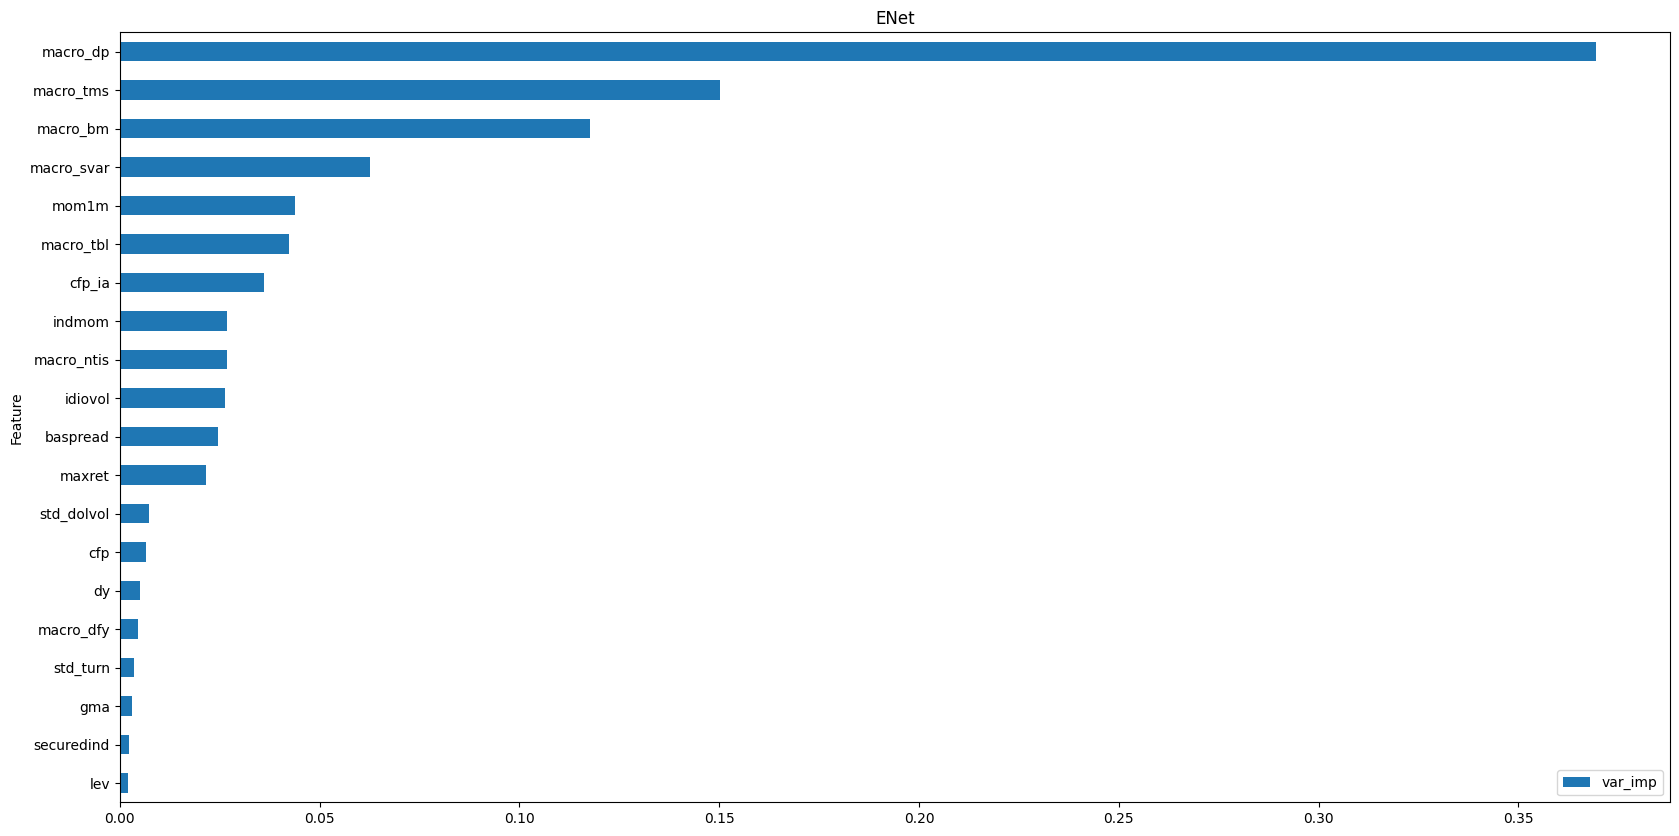

In [8]:
fea_imp_graph = imp.sort_values(['var_imp', 'Feature'], ascending=[True, False]).iloc[-20:]
_ = fea_imp_graph.plot(kind='barh', x='Feature', y='var_imp', figsize=(20, 10))
plt.title('ENet')
plt.show()

In [9]:
var_imp_net=imp[["Feature", "var_imp"]]
var_imp_net.to_csv(r'var_imp_net.csv', index = False)

In [ ]:
yhat = predictions_all.tolist()
y_true = y_test_list_all.tolist()
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })


results["identifier"]= results["identifier"].astype("str")
results["date"] = results["identifier"].str[12:22]
results["id"] = results["identifier"].str[35:40]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results.head()

# results['yhat'] = results['yhat'].apply(lambda x: x[0])
results['y_true'] = results['y_true'].apply(lambda x: x[0])

data = df[['mvel12', 'macro_tbl', 'macro_svar']].copy()
data.reset_index(inplace=True)
data['permno2'] = data['permno2'].astype('str')
data['MonthYear'] = data['DATE2'].dt.to_period('M')
data.drop('DATE2', axis=1, inplace=True)
data.rename(columns={'permno2': 'id'}, inplace=True)
data.rename(columns={'mvel12': 'market_cap'}, inplace=True)
data.rename(columns={'macro_tbl': 'risk_free_rate'}, inplace=True)
data = data.set_index(['MonthYear','id'])

bigdata = pd.merge(results, data,left_index=True, right_index=True)
bigdata.reset_index(inplace=True)
bigdata.head()
bigdata['returns'] = bigdata['y_true'] + bigdata['risk_free_rate']

In [ ]:
bigdata['MonthYear1'] = bigdata['MonthYear'].copy()
bigdata['MonthYear'] = bigdata['MonthYear'].astype('int64')
bigdata['NumMonth'] = bigdata['MonthYear'] - 83
bigdata['NumMonth'].unique()

In [ ]:
bigdata.to_csv('predictions/enet.csv', index=False)

In [ ]:
bigdata = pd.read_csv('predictions/enet.csv')

In [ ]:
top_100 = bigdata.sort_values(['NumMonth','yhat'], ascending=[True, True]).groupby(['MonthYear'],
                                                                  as_index=False,
                                                                  sort=False).tail(100)

In [ ]:
portfolio = top_100[['date', 'NumMonth','MonthYear', 'id', 'yhat', 'y_true', 'risk_free_rate', 'MonthYear1']]
portfolio.reset_index(inplace=True)
portfolio.drop(columns=['index'],inplace=True)
portfolio['eq_weights'] = 1/portfolio.groupby('MonthYear')['id'].transform('size')
portfolio['excess_return_stock_ew'] = portfolio['y_true'] *portfolio['eq_weights']
portfolio['pred_excess_return_stock_ew'] = portfolio["yhat"]*portfolio["eq_weights"]

In [ ]:
mean_pred_return = portfolio.groupby('MonthYear')['pred_excess_return_stock_ew'].transform('sum').mean()
mean_port_return = portfolio.groupby('MonthYear')['excess_return_stock_ew'].transform('sum').mean()
port_vol =  portfolio.groupby('MonthYear')["pred_excess_return_stock_ew"].transform('sum').std()
sharp_ratio = (mean_pred_return/port_vol)*np.sqrt(12)

In [ ]:
chart_np = np.array([[mean_port_return, mean_pred_return, port_vol, sharp_ratio]])

ew_df = pd.DataFrame(chart_np, columns=['Real', 'Pred', 'Std', 'Sharpe'],
                                index=['Elastic Net'])

ew_df['Real'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Real']], index= ew_df.index)
ew_df['Pred'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Pred']], index= ew_df.index)
ew_df['Std'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Std']], index= ew_df.index)
ew_df['Sharpe'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Sharpe']], index= ew_df.index)
ew_df


In [ ]:
pd.DataFrame(num_coef_time.items())
num_coef =pd.DataFrame(num_coef_time.items(), columns=['Identifier', 'num_coef'])
num_coef['Identifier'] = num_coef['Identifier'].astype(str)
num_coef["time"] = num_coef["Identifier"].str[20:30]
num_coef.drop(["Identifier"], axis = 1, inplace = True)

#Plot time-varying model complexity
num_coef.set_index('time').plot()
plt.xticks(rotation=45);

In [ ]:
num_coef.to_csv(r'comp_enet.csv')